# OVERVIEW

- MOTIVATION:
	- Previous investigation show that the base model and the chat model almost give similar performance in **next token prediction**
	- So it becomes interesting what is their difference?
		- -- >Investigate the difference in parameter between the base model and the  chat model
		- find out the parameters with big changes
			- can we use SAE features to understand which parameters are changed in the future?

# SET UP

In [1]:
import os
import transformer_lens
from transformer_lens import HookedTransformer
from transformer_lens import utils
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import accelerate
import bitsandbytes
import torch
import plotly
import plotly.express as px
import einops
import numpy as np
import psutil
import pandas as pd


In [2]:
SEED = 42
torch.set_grad_enabled(False)

In [18]:
# Key Helpers
def to_numpy(tensor):
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, list):
        # if isinstance(tensor[0])
        tensor = list(map(to_numpy, tensor))
        array = np.array(tensor)
        if array.dtype != np.dtype("O"):
            return array
        else:
            return to_numpy_ragged_2d(tensor)
    elif isinstance(tensor, (torch.Tensor, torch.nn.parameter.Parameter)):
        if tensor.dtype == torch.bfloat16:
            tensor = tensor.float()
        return tensor.detach().cpu().numpy()
    elif type(tensor) in [int, float, bool, str]:
        return np.array(tensor)
    elif isinstance(tensor, pd.Series):
        return tensor.values
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")

# LOAD MODEL

In [3]:
LLAMA_PATH_7b_chat = "D:/Data/Llama/Llama_2/7b_chat_hf"
LLANA_NAME_7b_chat = "meta-llama/Llama-2-7b-chat-hf"

LLAMA_PATH_7b = "D:/Data/Llama/Llama_2/7b_hf"
LLANA_NAME_7b = "meta-llama/Llama-2-7b-hf"

inference_type = torch.float32


In [4]:
model_7b = AutoModelForCausalLM.from_pretrained(LLAMA_PATH_7b,
                                               device_map='cuda:0',
                                               torch_dtype=inference_type,
                                               quantization_config=BitsAndBytesConfig(load_in_4bit=True))
tokenizer_7b = AutoTokenizer.from_pretrained(LLAMA_PATH_7b)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "tota(GB):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 5.47356672 tota(GB): 11.81089792
CPU percentage: 2.1


In [6]:

model_7b_chat = AutoModelForCausalLM.from_pretrained(LLAMA_PATH_7b_chat,
                                                     device_map='cuda:0',
                                                     torch_dtype=inference_type,
                                                     quantization_config=BitsAndBytesConfig(load_in_4bit=True))
tokenizer_7b_chat = AutoTokenizer.from_pretrained(LLAMA_PATH_7b_chat)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "total(GB):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 0.590548992 total(GB): 11.81089792
CPU percentage: 13.5


In [8]:

model_tl_7b = HookedTransformer.from_pretrained(LLANA_NAME_7b,
                                             hf_model=model_7b,
                                             dtype=inference_type,
                                             fold_ln=False,
                                             fold_value_biases=False,
                                             center_writing_weights=False,
                                             center_unembed=False,
                                             tokenizer=tokenizer_7b,
                                             device = "cpu")


Loaded pretrained model meta-llama/Llama-2-7b-hf into HookedTransformer


In [9]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "total0Gb):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 0.588845056 total0Gb): 11.81089792
CPU percentage: 30.5


In [10]:
inference_dtype = torch.float32

model_tl_7b_chat = HookedTransformer.from_pretrained(LLANA_NAME_7b_chat,
                                             hf_model=model_7b_chat,
                                             dtype=inference_dtype,
                                             fold_ln=False,
                                             fold_value_biases=False,
                                             center_writing_weights=False,
                                             center_unembed=False,
                                             tokenizer=tokenizer_7b_chat,
                                             device = "cpu")


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


In [11]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "total(GB):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 0.590548992 total(GB): 11.81089792
CPU percentage: 28.3


# All Parameters Across Layers

In [95]:
param_diff_all={}
for layer in np.arange(model_tl_7b.cfg.n_layers):
    param_diff = []
    for (name, param),(name_chat, param_chat) in zip(model_tl_7b.named_parameters(), model_tl_7b_chat.named_parameters()):
        if name.startswith(f"blocks.{layer}."):
            print(name, param.shape)
            print(name_chat, param_chat.shape)
            param_diff = np.append(param_diff,(param-param_chat))
            param_diff_all[layer] = param_diff
    
            

blocks.0.ln1.w torch.Size([4096])
blocks.0.ln1.w torch.Size([4096])
blocks.0.ln2.w torch.Size([4096])
blocks.0.ln2.w torch.Size([4096])
blocks.0.attn.W_Q torch.Size([8388608, 1])
blocks.0.attn.W_Q torch.Size([8388608, 1])
blocks.0.attn.W_O torch.Size([8388608, 1])
blocks.0.attn.W_O torch.Size([8388608, 1])
blocks.0.attn.b_Q torch.Size([32, 128])
blocks.0.attn.b_Q torch.Size([32, 128])
blocks.0.attn.b_O torch.Size([4096])
blocks.0.attn.b_O torch.Size([4096])
blocks.0.attn.W_K torch.Size([8388608, 1])
blocks.0.attn.W_K torch.Size([8388608, 1])
blocks.0.attn.W_V torch.Size([8388608, 1])
blocks.0.attn.W_V torch.Size([8388608, 1])
blocks.0.attn.b_K torch.Size([32, 128])
blocks.0.attn.b_K torch.Size([32, 128])
blocks.0.attn.b_V torch.Size([32, 128])
blocks.0.attn.b_V torch.Size([32, 128])
blocks.0.mlp.W_in torch.Size([22544384, 1])
blocks.0.mlp.W_in torch.Size([22544384, 1])
blocks.0.mlp.W_gate torch.Size([22544384, 1])
blocks.0.mlp.W_gate torch.Size([22544384, 1])
blocks.0.mlp.W_out torch.S

In [86]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "total(GB):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 0.622718976 total(GB): 11.81089792
CPU percentage: 2.4


In [94]:
param_diff.shape

(4097,)

In [120]:
# instead of directly plot histogram
# (1) get counts and bins
# (2) then plot bar graph
# WHY?
# (1) So you can plot with large data set (px.histogram does not work on large dataset)
# (2) plot bar graph will allow you to have animation frames

bins_all = []
counts_all = []
layers_all = []
for ll in np.arange(model_tl_7b.cfg.n_layers):
    param_diff = to_numpy(param_diff_all[ll])
    counts,bins = np.histogram(param_diff,10)
    bins = 0.5*(bins[:-1]+ bins[1:])
    layer = ll*np.ones(len(bins))
    bins_all = np.append(bins_all,bins)
    counts_all = np.append(counts_all,counts)
    layers_all = np.append(layers_all,layer)
    # fig = px.bar(x=bins, y=counts)
    # fig.show()

In [130]:
df = pd.DataFrame()
df["bins"] = bins_all
df["counts"] = counts_all
df["layer"] = layers_all

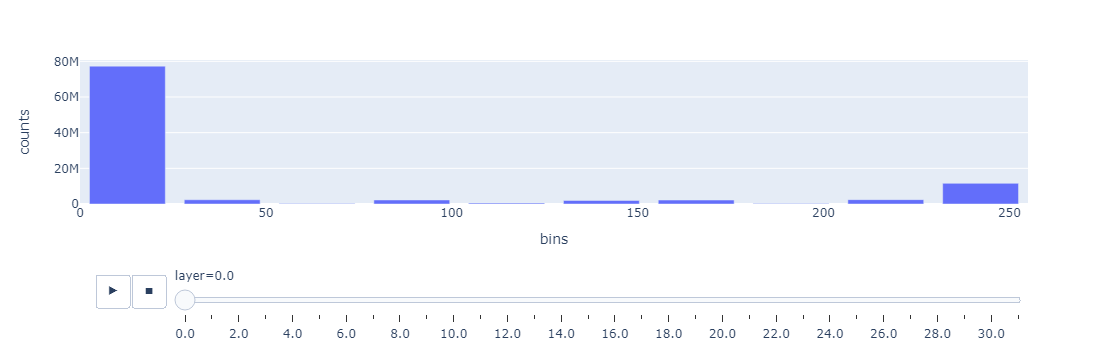

In [131]:
fig = px.bar(df, x='bins', y='counts', animation_frame='layer', range_y=[0,df['counts'].max()])

fig.show()

In [356]:
num_param = 0
param_name_qnique =[]
for (name, param),(name_chat, param_chat) in zip(model_tl_7b.named_parameters(), model_tl_7b_chat.named_parameters()):
    print(name)
   

embed.W_E
blocks.0.ln1.w
blocks.0.ln2.w
blocks.0.attn.W_Q
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_O
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.mlp.W_in
blocks.0.mlp.W_gate
blocks.0.mlp.W_out
blocks.0.mlp.b_in
blocks.0.mlp.b_out
blocks.1.ln1.w
blocks.1.ln2.w
blocks.1.attn.W_Q
blocks.1.attn.W_O
blocks.1.attn.b_Q
blocks.1.attn.b_O
blocks.1.attn.W_K
blocks.1.attn.W_V
blocks.1.attn.b_K
blocks.1.attn.b_V
blocks.1.mlp.W_in
blocks.1.mlp.W_gate
blocks.1.mlp.W_out
blocks.1.mlp.b_in
blocks.1.mlp.b_out
blocks.2.ln1.w
blocks.2.ln2.w
blocks.2.attn.W_Q
blocks.2.attn.W_O
blocks.2.attn.b_Q
blocks.2.attn.b_O
blocks.2.attn.W_K
blocks.2.attn.W_V
blocks.2.attn.b_K
blocks.2.attn.b_V
blocks.2.mlp.W_in
blocks.2.mlp.W_gate
blocks.2.mlp.W_out
blocks.2.mlp.b_in
blocks.2.mlp.b_out
blocks.3.ln1.w
blocks.3.ln2.w
blocks.3.attn.W_Q
blocks.3.attn.W_O
blocks.3.attn.b_Q
blocks.3.attn.b_O
blocks.3.attn.W_K
blocks.3.attn.W_V
blocks.3.attn.b_K
blocks.3.attn.b_V
blocks.3.mlp

# Histogram By Parameter Type

In [16]:
num_param = 0
param_name_unique =[]
param_block_unique = []
for (name, param),(name_chat, param_chat) in zip(model_tl_7b.named_parameters(), model_tl_7b_chat.named_parameters()):
    # print(name)
    num_param = num_param+1
    if name.startswith(f"blocks.0") or name.startswith("embed") or name.startswith("ln_final") or name.startswith("unembed"):
        print(name)
        param_name = name.split(".")[-1]
        param_block = name.split(".")[-2]
        param_name_unique = np.append(param_name_unique,param_name)
        param_block_unique = np.append(param_block_unique,param_block)



embed.W_E
blocks.0.ln1.w
blocks.0.ln2.w
blocks.0.attn.W_Q
blocks.0.attn.W_O
blocks.0.attn.b_Q
blocks.0.attn.b_O
blocks.0.attn.W_K
blocks.0.attn.W_V
blocks.0.attn.b_K
blocks.0.attn.b_V
blocks.0.mlp.W_in
blocks.0.mlp.W_gate
blocks.0.mlp.W_out
blocks.0.mlp.b_in
blocks.0.mlp.b_out
ln_final.w
unembed.W_U
unembed.b_U


In [19]:
df_hist = pd.DataFrame()

param_name_all = []
param_block_all = []
param_layer_all = []
bins_all = []
counts_all = []
bin_num_all = []
cc =0
for (name, param),(name_chat, param_chat) in zip(model_tl_7b.named_parameters(), model_tl_7b_chat.named_parameters()):
    
    if name.startswith(f"blocks."):
        param_name = name.split(".")[-1]
        param_block = name.split(".")[2]
        param_layer = name.split(".")[1]
        bin_num = np.arange(10)
        # print(param_block)
        # print(param_layer)
        for ll in np.arange(10):
            param_name_all = np.append(param_name_all,param_name)
            param_block_all = np.append(param_block_all,param_block)
            param_layer_all = np.append(param_layer_all,param_layer)

    else:
        param_name = name.split(".")[-1]
        param_block = " "
        param_layer = name.split(".")[0]
        bin_num = np.arange(10)

        # print(param_name)
        # print(param_block)
        # print(param_layer) 
        for ll in np.arange(10):
            param_name_all = np.append(param_name_all,param_name)
            param_block_all = np.append(param_block_all,param_block)
            param_layer_all = np.append(param_layer_all,param_layer)

    print(name)
    param_diff = param-param_chat
    param_diff = to_numpy(param_diff)
    print(f"min param diff: {np.min(param_diff)}")
    counts,bins = np.histogram(param_diff,10)
    bins = 0.5*(bins[:-1]+ bins[1:])
    bins_all = np.append(bins_all,bins)
    counts_all = np.append(counts_all,counts)
    bin_num_all = np.append(bin_num_all,bin_num)

    cc = cc+1

df_hist["param_layer_all"] = param_layer_all
df_hist["param_block_all"] = param_block_all
df_hist["param_name_all"] = param_name_all
df_hist["counts_all"] = counts_all
df_hist["bins_all"] = bins_all
df_hist["bin_num_all"] = bin_num_all


embed.W_E
min param diff: -0.006591796875
blocks.0.ln1.w
min param diff: -0.0037841796875
blocks.0.ln2.w
min param diff: -0.0029296875
blocks.0.attn.W_Q
min param diff: 0
blocks.0.attn.W_O
min param diff: 0
blocks.0.attn.b_Q
min param diff: 0.0
blocks.0.attn.b_O
min param diff: 0.0
blocks.0.attn.W_K
min param diff: 0
blocks.0.attn.W_V
min param diff: 0
blocks.0.attn.b_K
min param diff: 0.0
blocks.0.attn.b_V
min param diff: 0.0
blocks.0.mlp.W_in
min param diff: 0
blocks.0.mlp.W_gate
min param diff: 0
blocks.0.mlp.W_out
min param diff: 0
blocks.0.mlp.b_in
min param diff: 0.0
blocks.0.mlp.b_out
min param diff: 0.0
blocks.1.ln1.w
min param diff: -0.002197265625
blocks.1.ln2.w
min param diff: -0.00244140625
blocks.1.attn.W_Q
min param diff: 0
blocks.1.attn.W_O
min param diff: 0
blocks.1.attn.b_Q
min param diff: 0.0
blocks.1.attn.b_O
min param diff: 0.0
blocks.1.attn.W_K
min param diff: 0
blocks.1.attn.W_V
min param diff: 0
blocks.1.attn.b_K
min param diff: 0.0
blocks.1.attn.b_V
min param di

In [296]:
df

param_layer_all param_block_all param_name_all  counts_all  bins_all  \
0              embed                            W_E       172.0 -0.005936   
1              embed                            W_E     17972.0 -0.004623   
2              embed                            W_E    738422.0 -0.003311   
3              embed                            W_E   9420489.0 -0.001999   
4              embed                            W_E  51912061.0 -0.000687   
...              ...             ...            ...         ...       ...   
4835         unembed                            b_U     32000.0  0.050000   
4836         unembed                            b_U         0.0  0.150000   
4837         unembed                            b_U         0.0  0.250000   
4838         unembed                            b_U         0.0  0.350000   
4839         unembed                            b_U         0.0  0.450000   

      bin_num_all  
0             0.0  
1             1.0  
2             2.0  
3             3.0  
4             4.0  
...           ...  
4835          5.0  
4836          6.0  
4837          7.0  
4838          8.0  
4839          9.0  

[4840 rows x 6 columns]

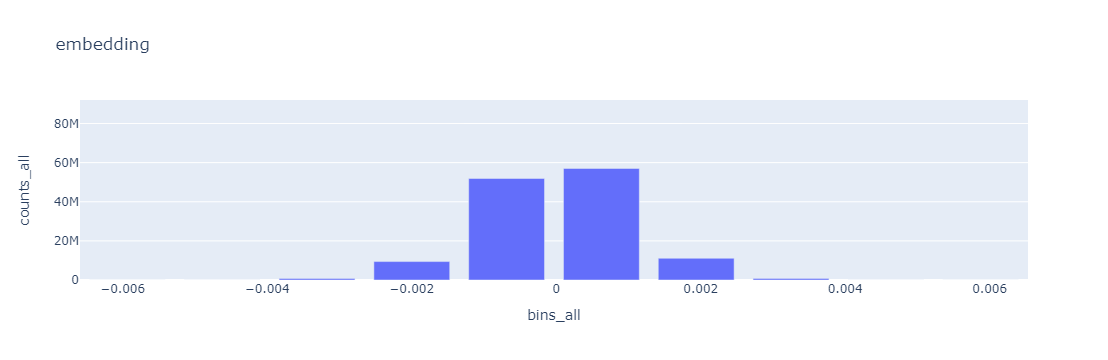

In [20]:
df_plot = df_hist[df_hist['param_name_all'] == 'W_E'] 
fig = px.bar(df_plot,
             x='bins_all', y='counts_all',
             range_y=[0,df_hist['counts_all'].max()],
             title = "embedding")

fig.show()

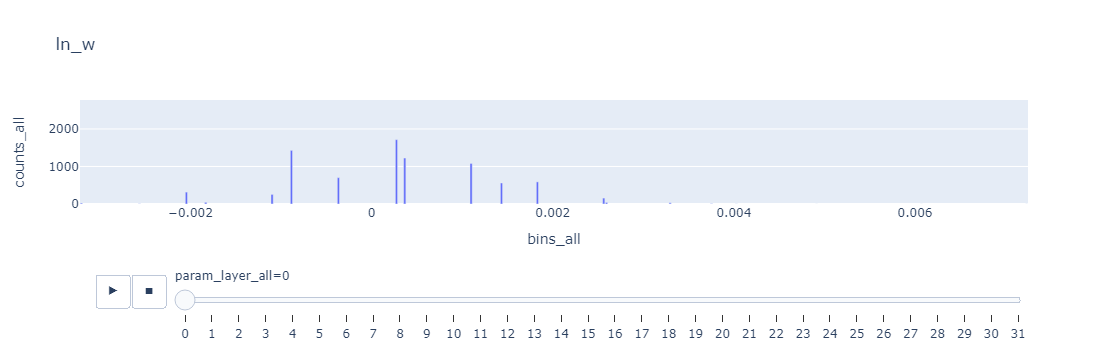

In [268]:
df_plot = df[df['param_block_all'] !=  " "]
df_plot = df_plot[df_plot['param_name_all'] ==  "w"]
fig = px.bar(df_plot,
             x='bins_all', y='counts_all',
             range_y=[0,df_plot['counts_all'].max()],
             title = "ln_w",
             animation_frame = "param_layer_all")

fig.show()


In [421]:
df_plot

param_layer_all param_block_all param_name_all  counts_all  bins_all  \
30                 0            attn            W_Q   6917328.0     12.75   
31                 0            attn            W_Q    106758.0     38.25   
32                 0            attn            W_Q     16091.0     63.75   
33                 0            attn            W_Q    155328.0     89.25   
34                 0            attn            W_Q     46750.0    114.75   
...              ...             ...            ...         ...       ...   
4685              31            attn            W_Q    141790.0    140.25   
4686              31            attn            W_Q    161373.0    165.75   
4687              31            attn            W_Q     16723.0    191.25   
4688              31            attn            W_Q    193986.0    216.75   
4689              31            attn            W_Q    916254.0    242.25   

      bin_num_all  
30            0.0  
31            1.0  
32            2.0  
33            3.0  
34            4.0  
...           ...  
4685          5.0  
4686          6.0  
4687          7.0  
4688          8.0  
4689          9.0  

[320 rows x 6 columns]

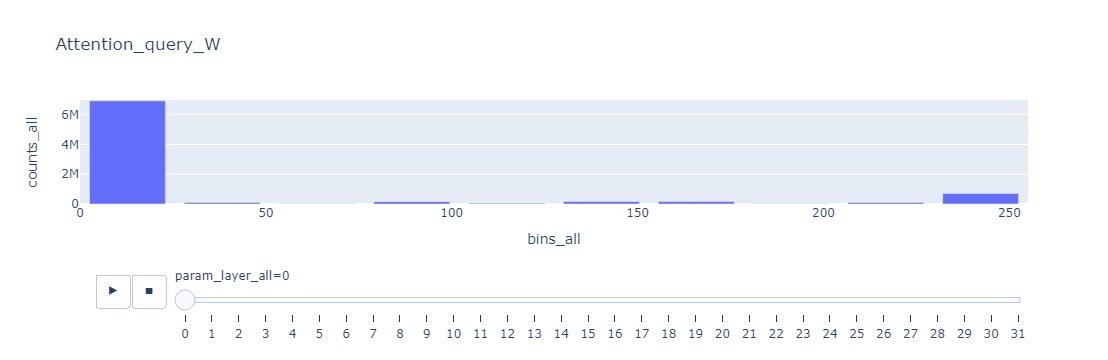

In [420]:
df_plot = df_hist[df_hist['param_name_all'] ==  "W_Q"]
fig = px.bar(df_plot,
             x='bins_all', y='counts_all',
             range_y=[0,df_plot['counts_all'].max()],
             title = "Attention_query_W",
             animation_frame = "param_layer_all")

fig.show()


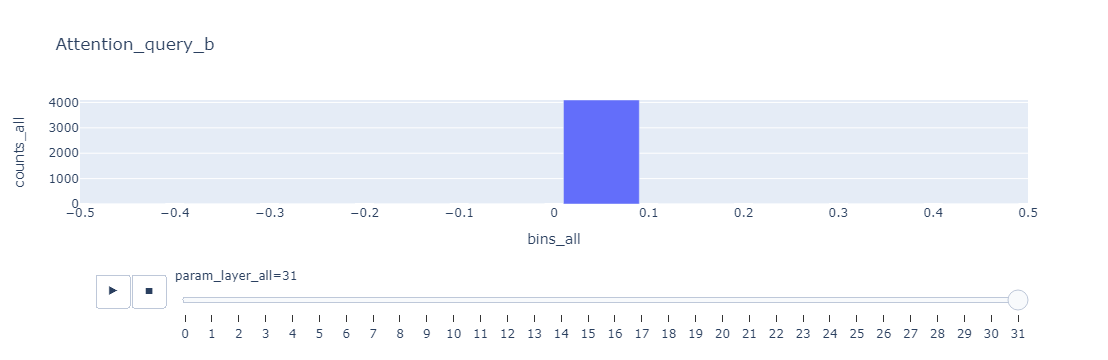

In [275]:
df_plot = df_hist[df_hist['param_name_all'] ==  "b_Q"]
fig = px.bar(df_plot,
             x='bins_all', y='counts_all',
             range_y=[0,df_plot['counts_all'].max()],
             title = "Attention_query_b",
             animation_frame = "param_layer_all")

fig.show()


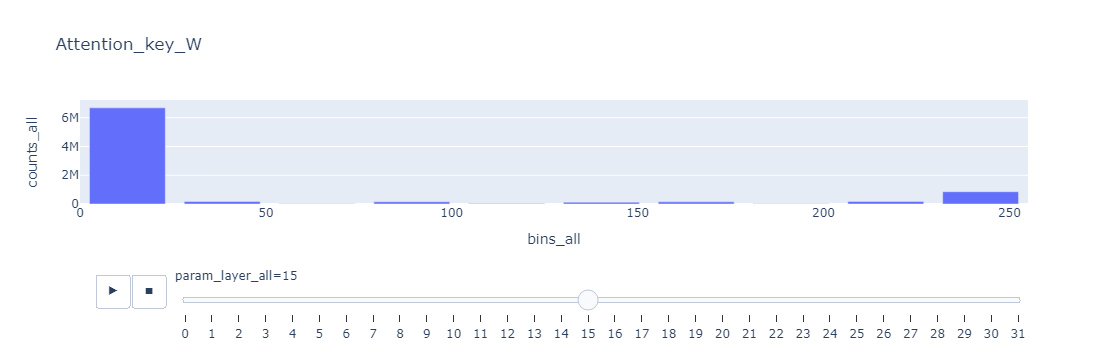

In [279]:
df_plot = df_hist[df_hist['param_name_all'] ==  "W_K"]
fig = px.bar(df_plot,
             x='bins_all', y='counts_all',
             range_y=[0,df_plot['counts_all'].max()],
             title = "Attention_key_W",
             animation_frame = "param_layer_all")

fig.show()


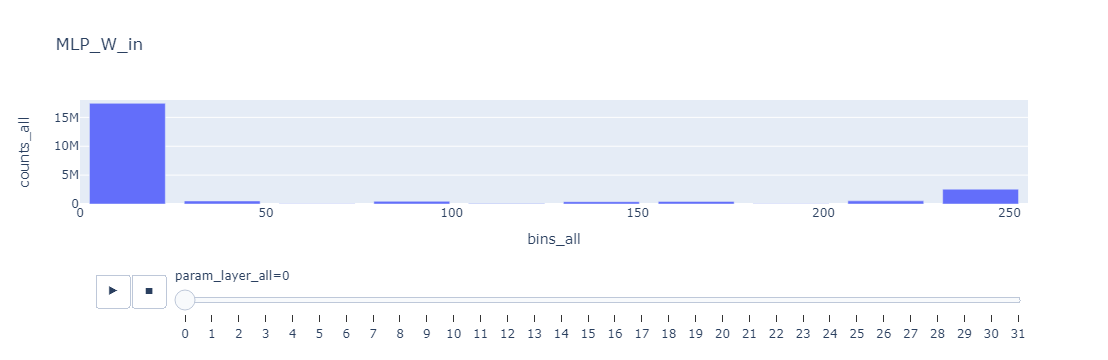

In [22]:
df_plot = df_hist[df_hist['param_name_all'] ==  "W_in"]
fig = px.bar(df_plot,
             x='bins_all', y='counts_all',
             range_y=[0,df_plot['counts_all'].max()],
             title = "MLP_W_in",
             animation_frame = "param_layer_all")

fig.show()


# Number of Parameters in the Smallest Change VS Biggest Change Group

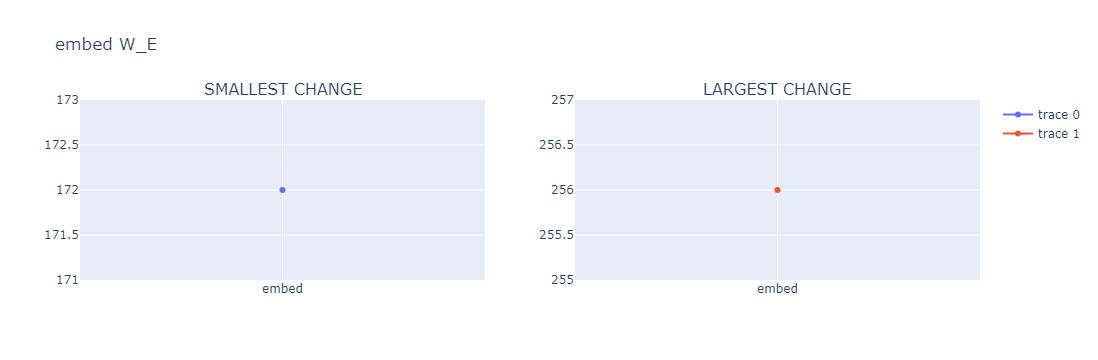

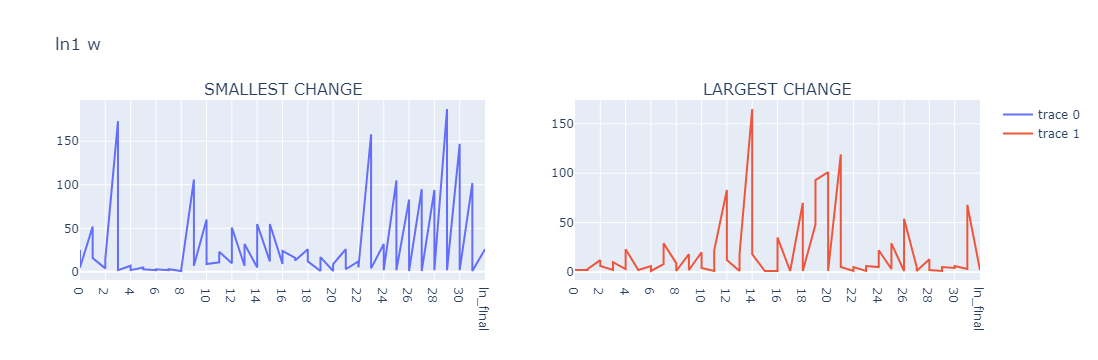

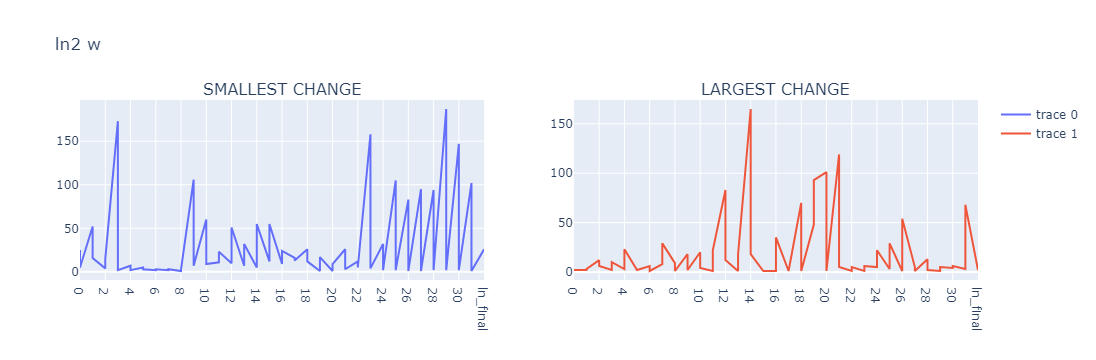

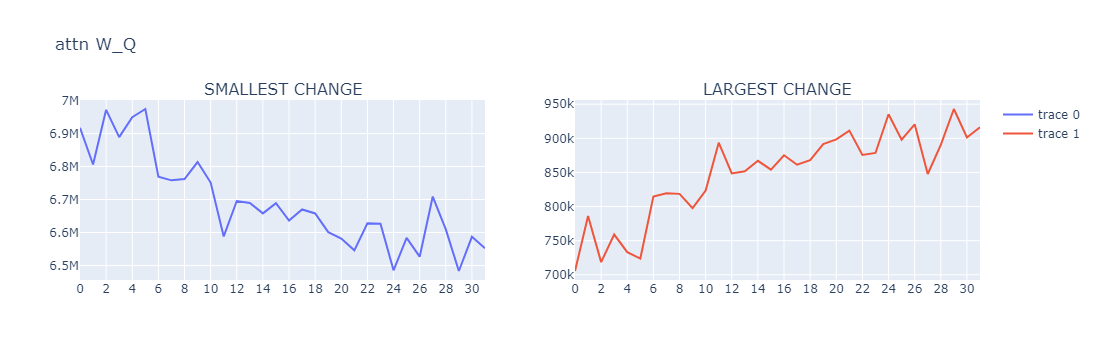

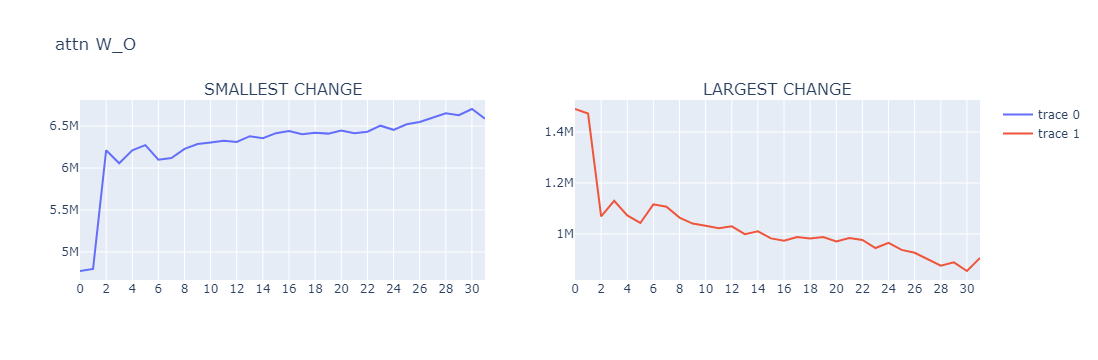

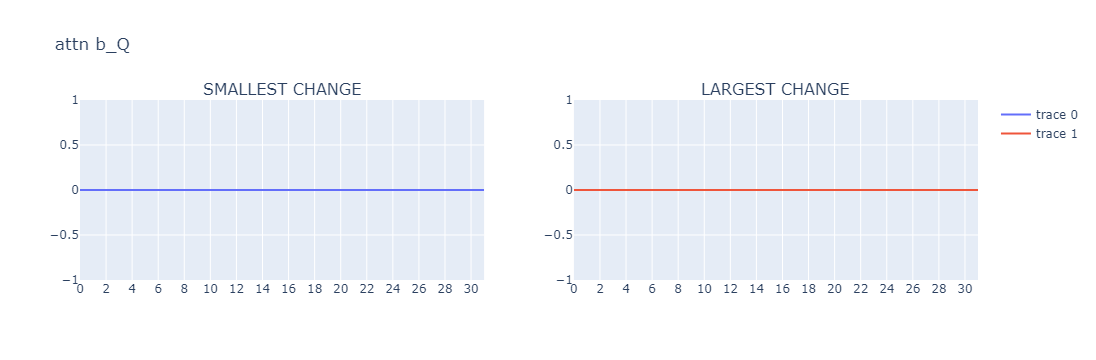

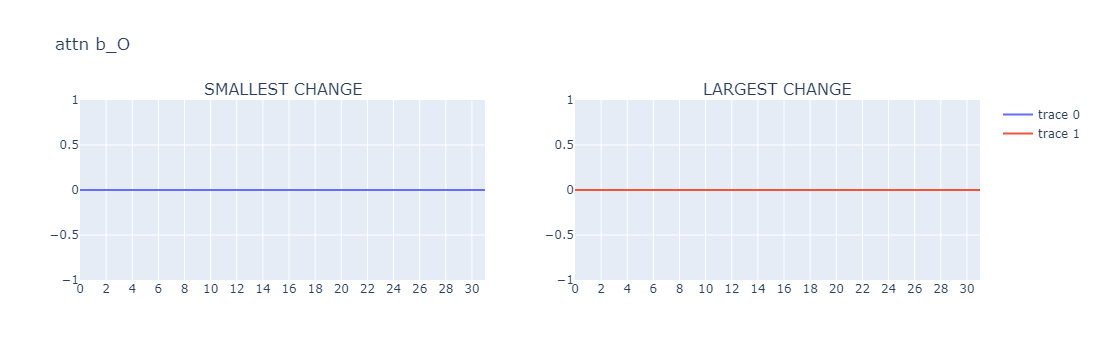

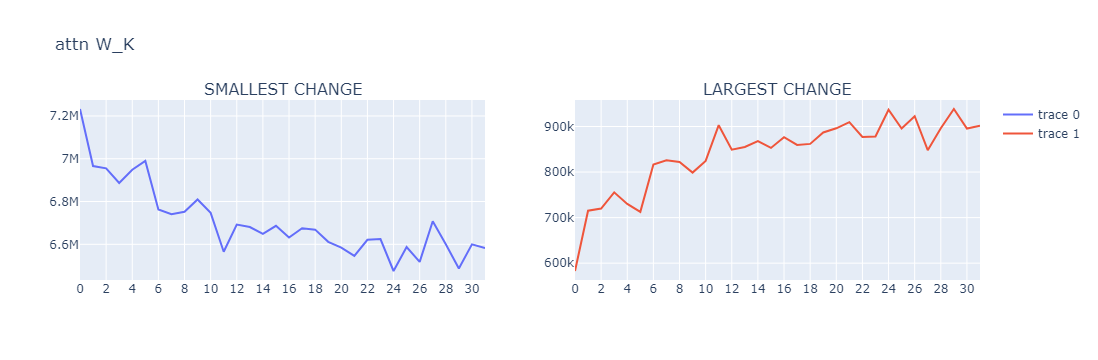

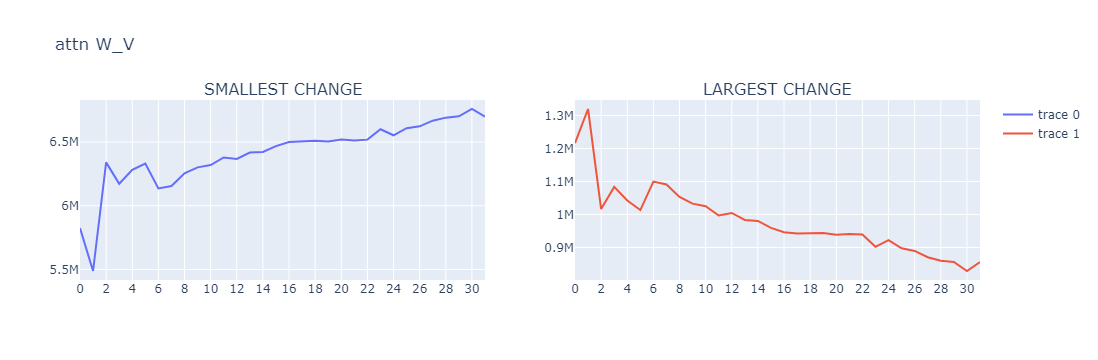

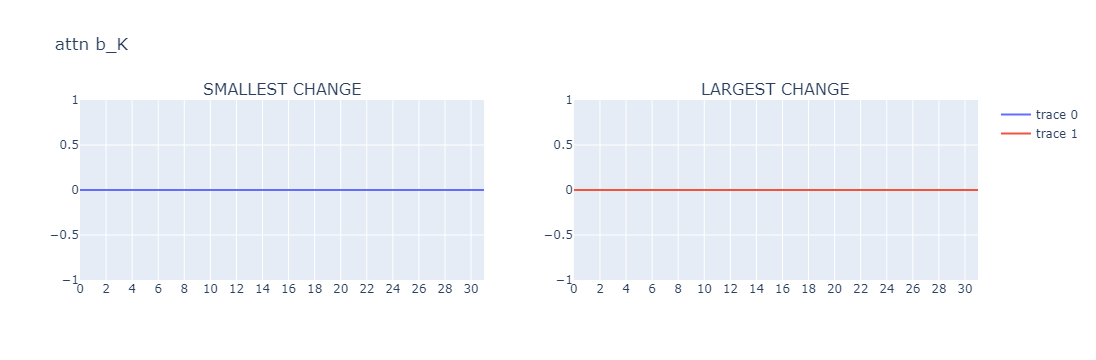

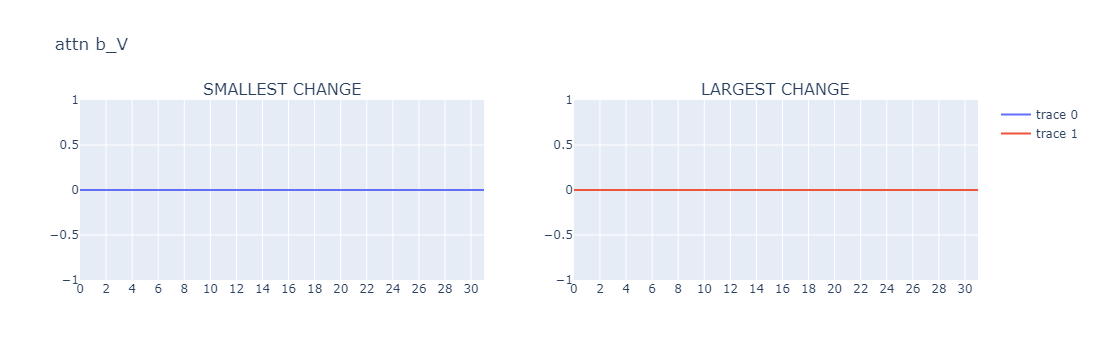

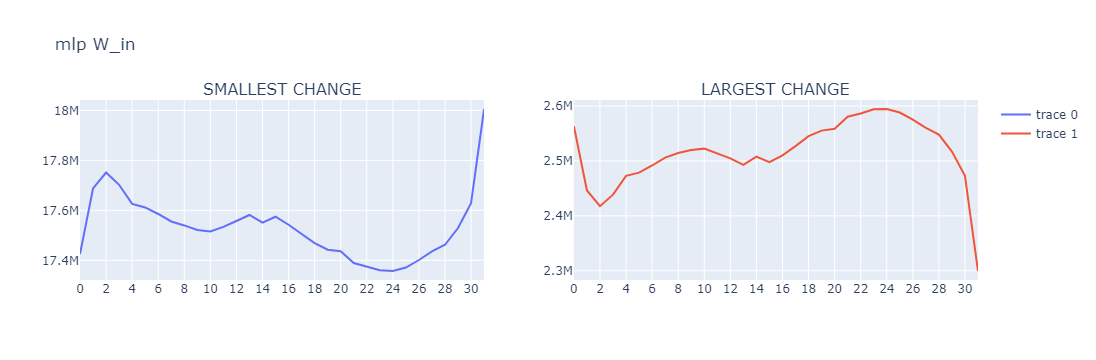

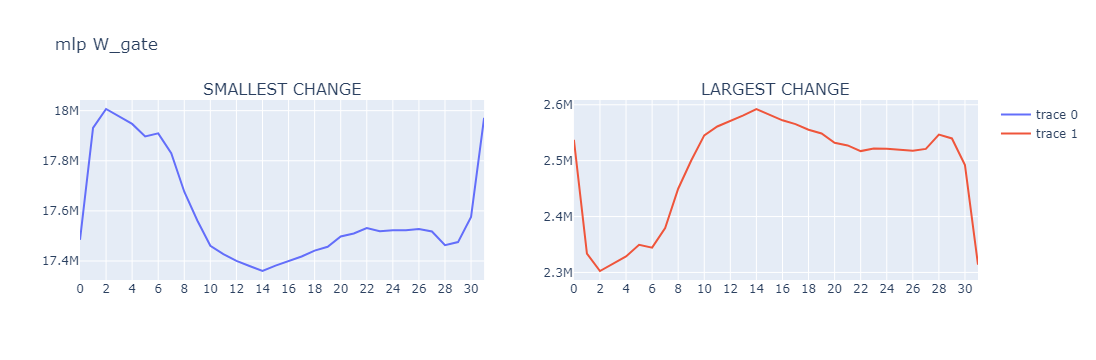

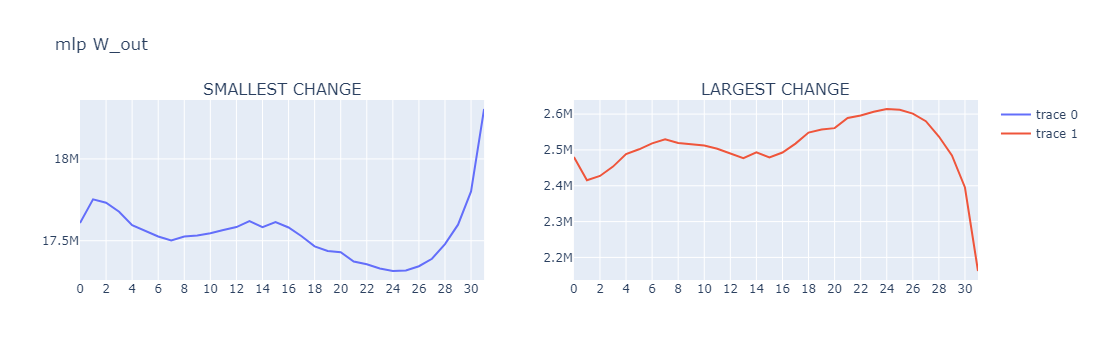

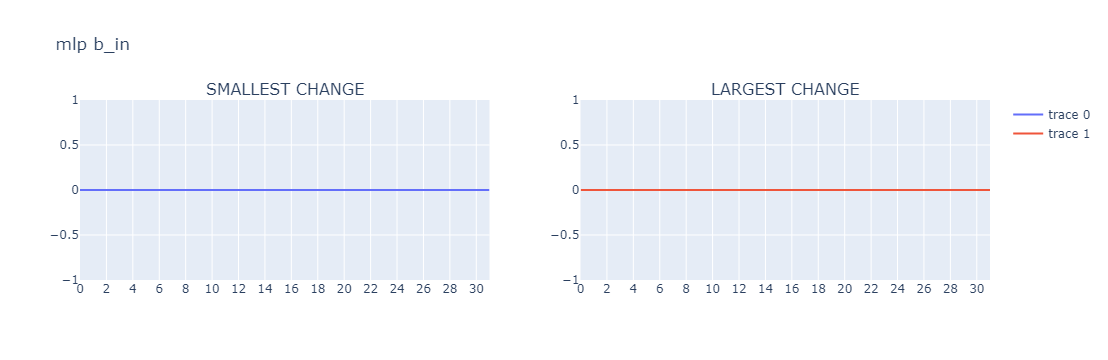

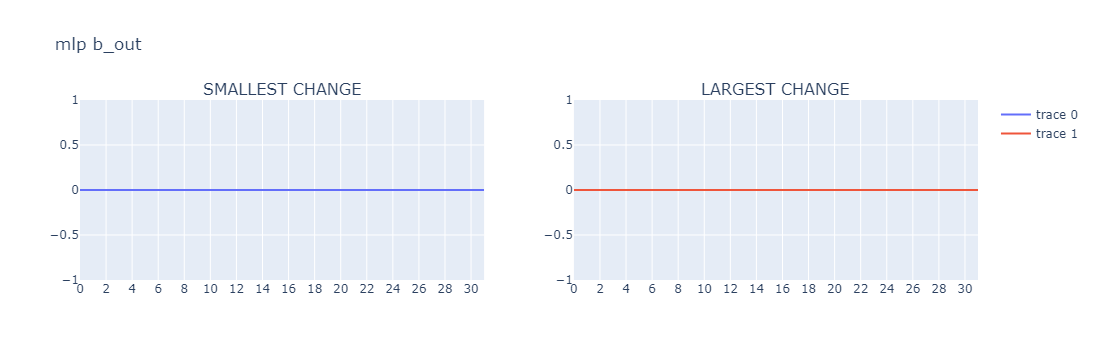

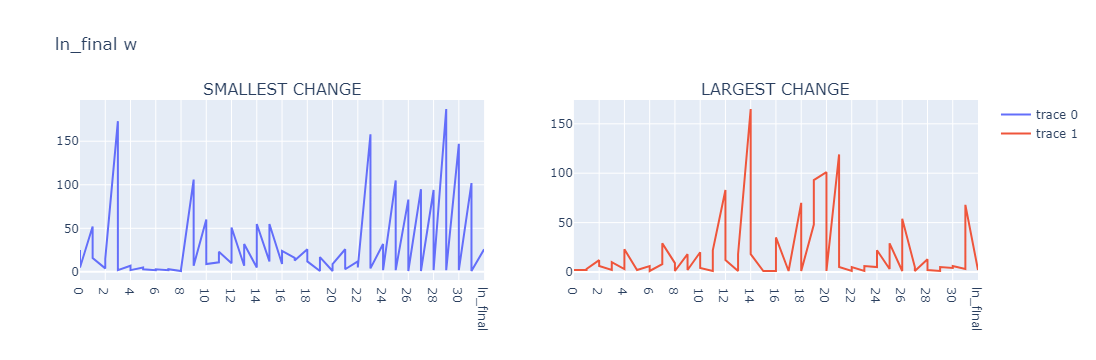

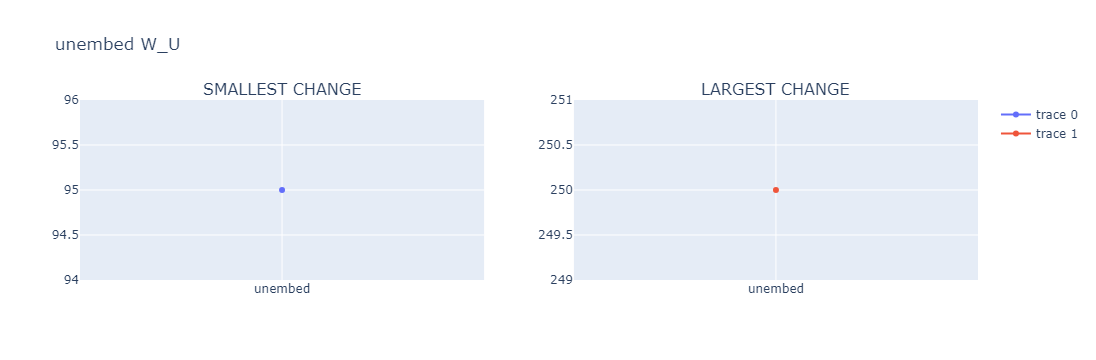

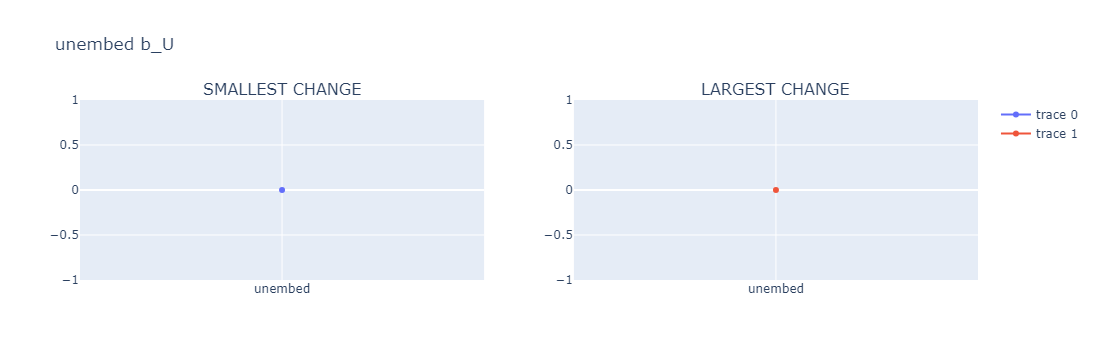

In [374]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
for name,block in zip(param_name_unique,param_block_unique):
    df_plot = df[df['param_name_all'] ==  name]
    
    fig = make_subplots(rows = 1, cols = 2,
                        subplot_titles=("SMALLEST CHANGE","LARGEST CHANGE"))
    
    df_plot_bin= df_plot[df_plot["bin_num_all"] == 0]
    fig.add_trace(
        go.Scatter(
                x = df_plot_bin["param_layer_all"].values, y = df_plot_bin["counts_all"].values),
                row=1,col=1)
    
    df_plot_bin= df_plot[df_plot["bin_num_all"] == 9]
    fig.add_trace(
        go.Scatter(
                x = df_plot_bin["param_layer_all"].values, y = df_plot_bin["counts_all"].values),
                row=1,col=2)
    
    fig.update_layout(title_text = block +" " +name)
    fig.show()

# Mean and Variance of Difference



In [ ]:
df = pd.DataFrame()

param_name_all = []
param_block_all = []
param_layer_all = []
mean_param_diff = []
std_param_diff = []
median_param_diff = []
first_quarter_param_diff = []
last_quarter_param_diff = []

cc =0
for (name, param),(name_chat, param_chat) in zip(model_tl_7b.named_parameters(), model_tl_7b_chat.named_parameters()):
    
    if name.startswith(f"blocks."):
        param_name = name.split(".")[-1]
        param_block = name.split(".")[2]
        param_layer = name.split(".")[1]
        # print(param_name)
        # print(param_block)
        # print(param_layer)
        param_name_all = np.append(param_name_all,param_name)
        param_block_all = np.append(param_block_all,param_block)
        param_layer_all = np.append(param_layer_all,param_layer)

    else:
        param_name = name.split(".")[-1]
        param_block = " "
        param_layer = name.split(".")[0]

        # print(param_name)
        # print(param_block)
        # print(param_layer) 
        param_name_all = np.append(param_name_all,param_name)
        param_block_all = np.append(param_block_all,param_block)
        param_layer_all = np.append(param_layer_all,param_layer)


    param_diff = abs(param-param_chat)
    param_diff = to_numpy(param_diff)
    mean_param_diff = np.append(mean_param_diff,np.mean(param_diff))
    std_param_diff = np.append(std_param_diff,np.std(param_diff))
    median_param_diff = np.append(median_param_diff,np.median(param_diff))
    first_quarter_param_diff = np.append(first_quarter_param_diff,np.percentile(param_diff,25))
    last_quarter_param_diff = np.append(last_quarter_param_diff,np.percentile(param_diff,75))

df["param_layer_all"] = param_layer_all
df["param_block_all"] = param_block_all
df["param_name_all"] = param_name_all
df["mean_param_diff"] = mean_param_diff
df["std_param_diff"] = std_param_diff
df["median_param_diff"] = median_param_diff
df["first_quarter_param_diff"] = first_quarter_param_diff
df["last_quarter_param_diff"] = last_quarter_param_diff

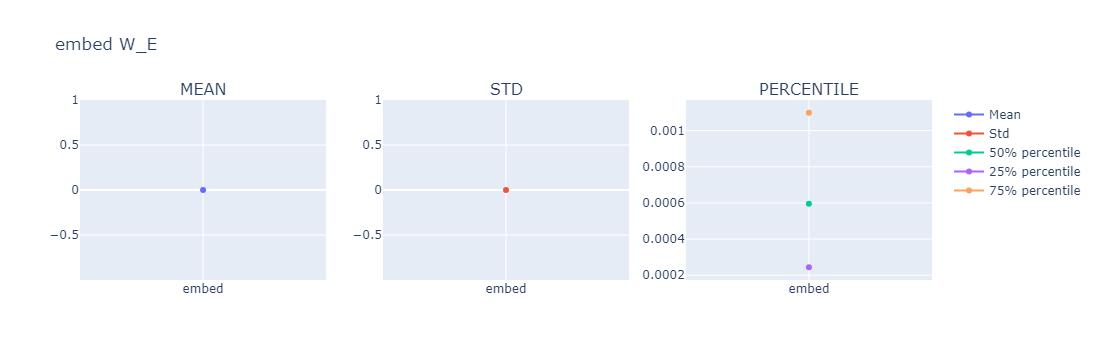

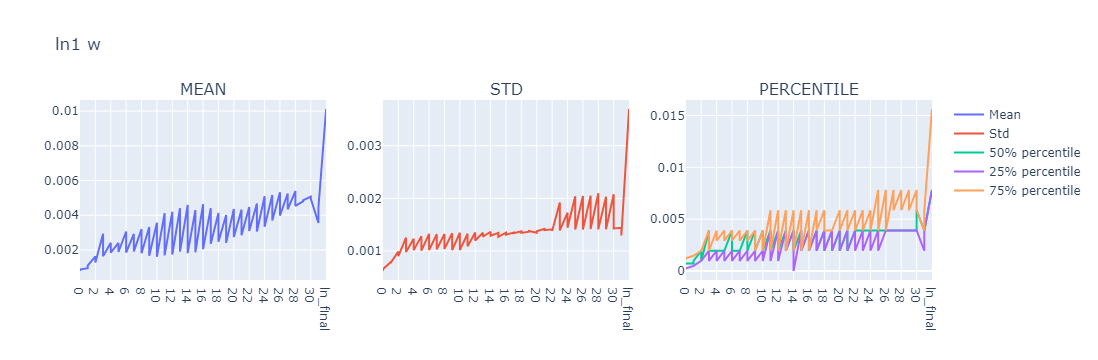

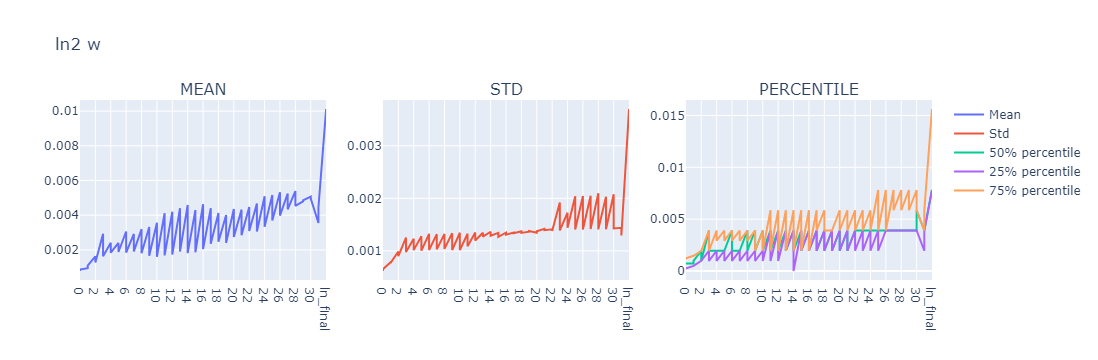

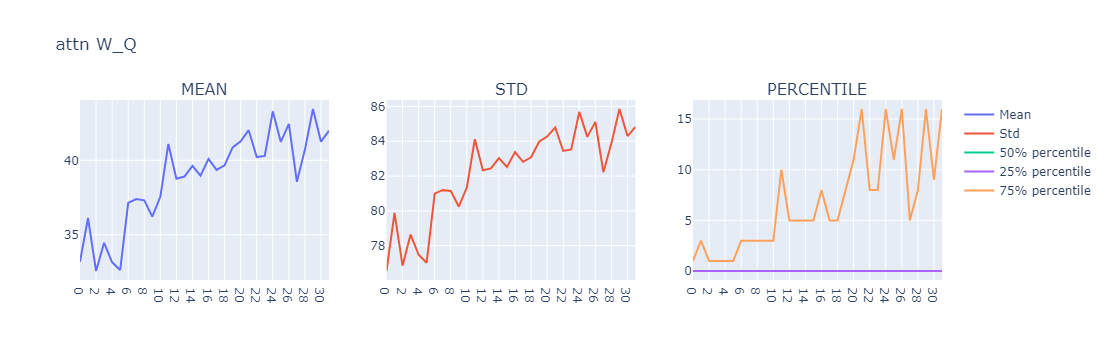

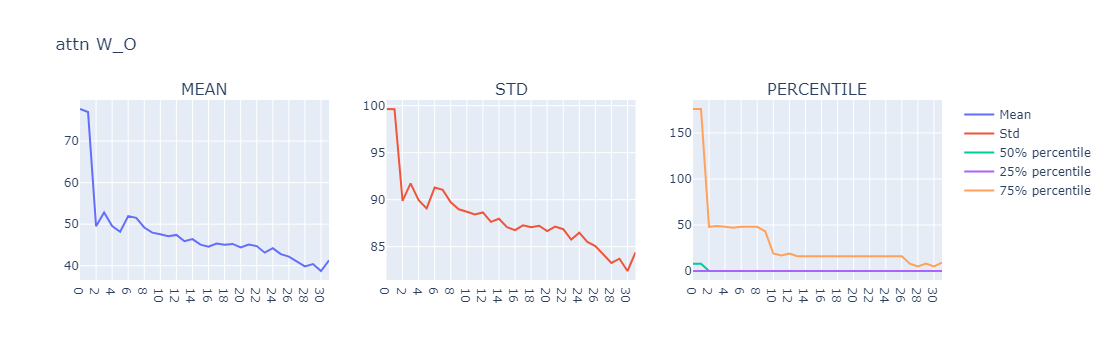

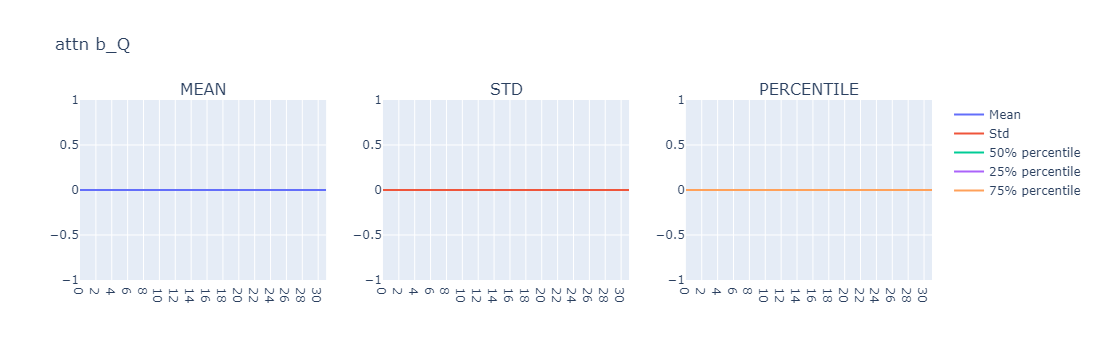

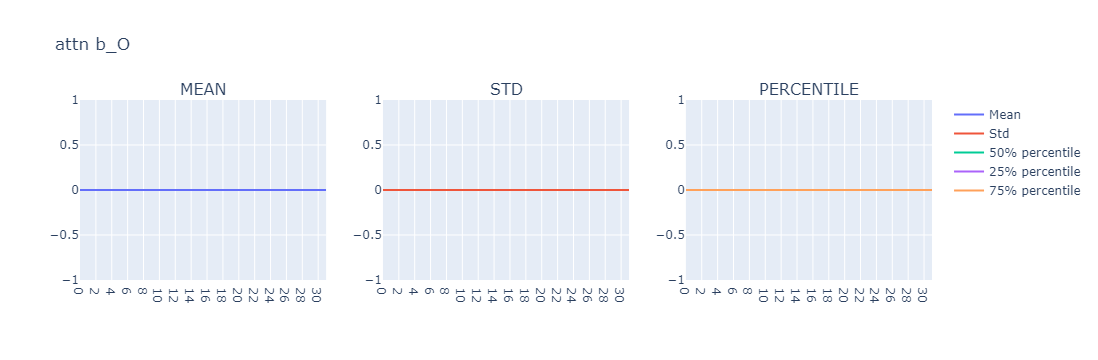

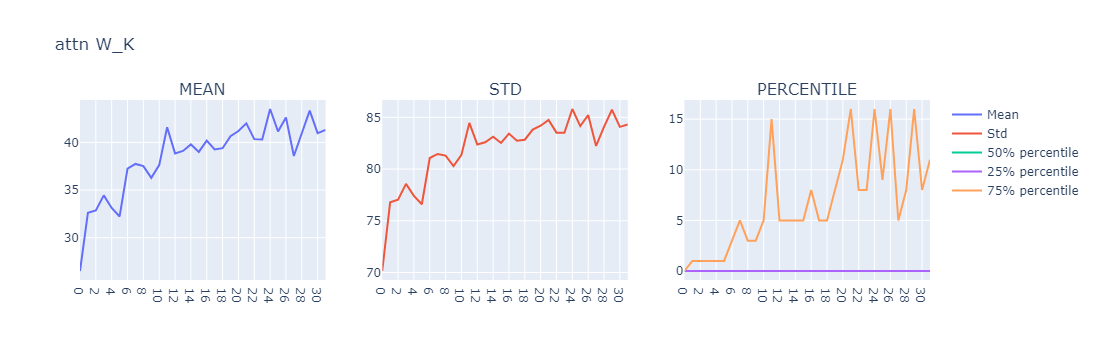

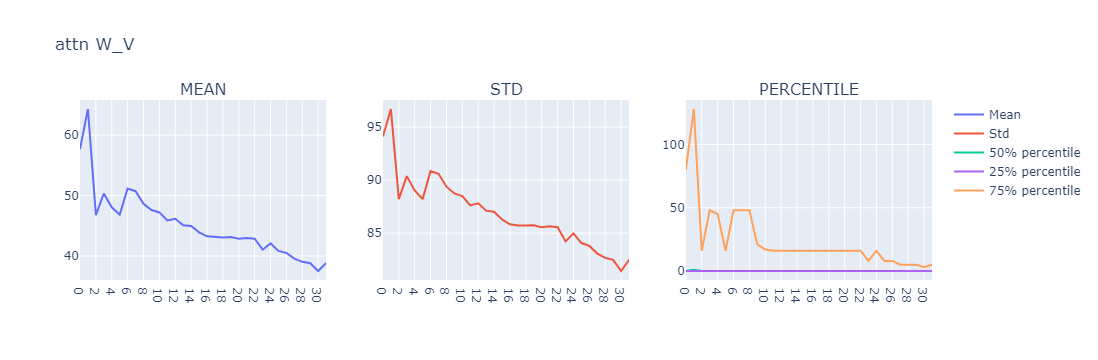

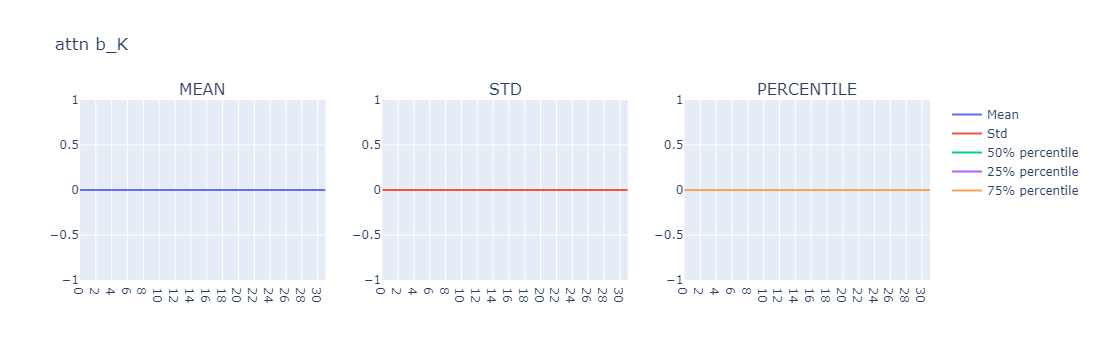

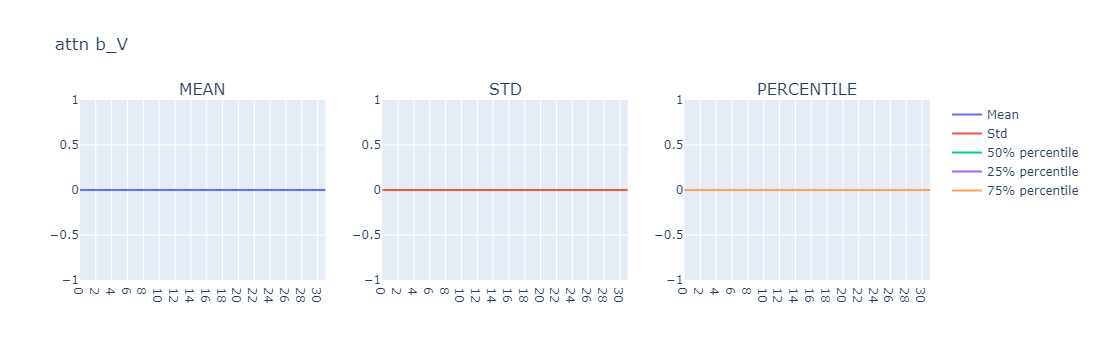

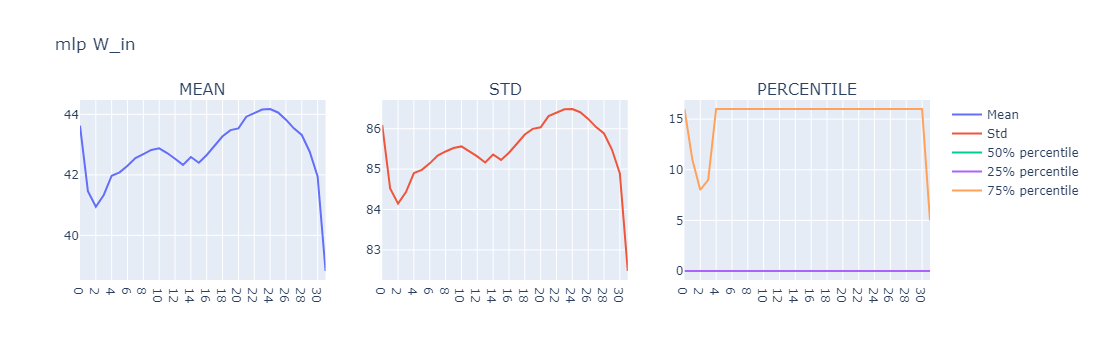

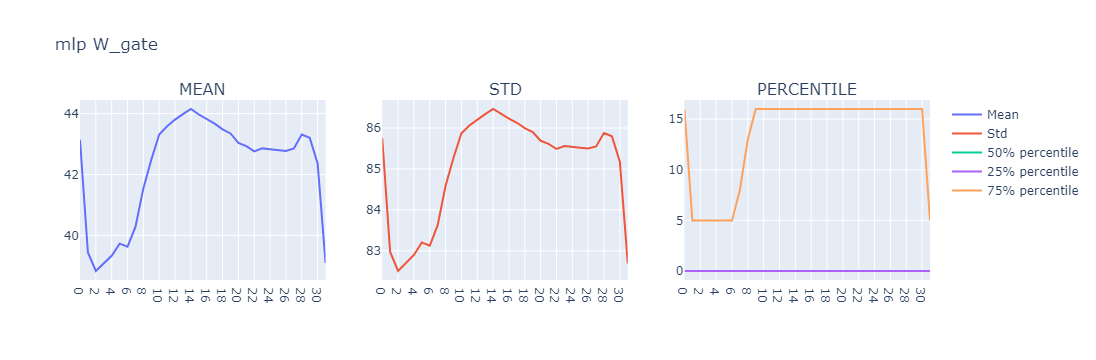

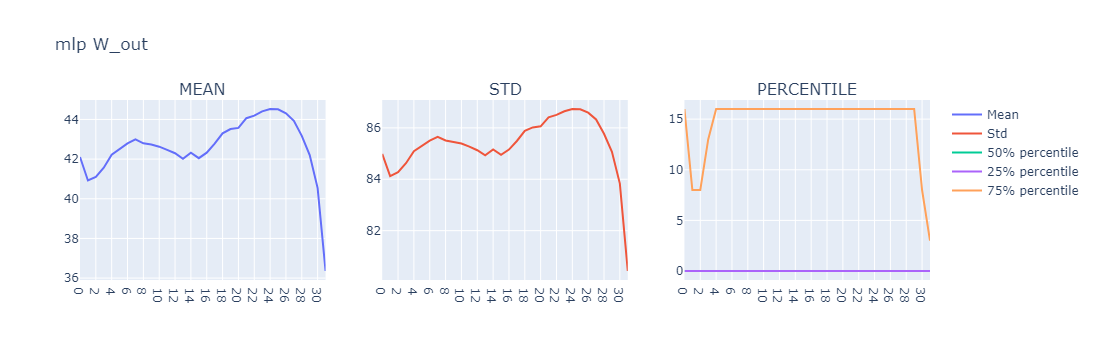

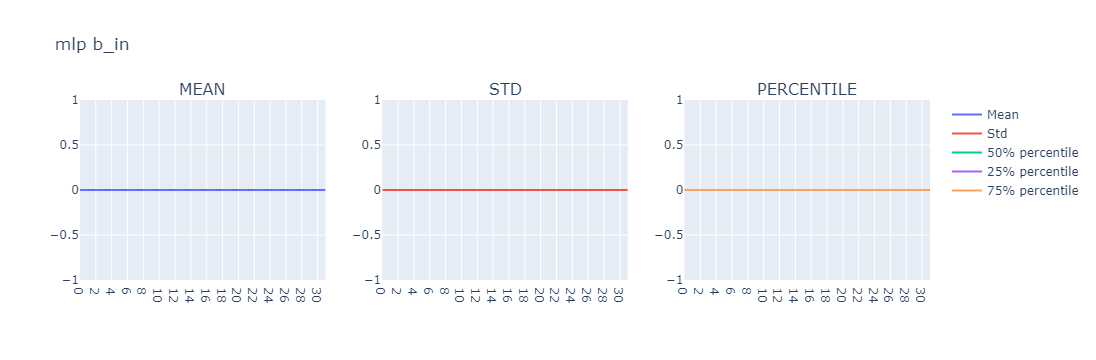

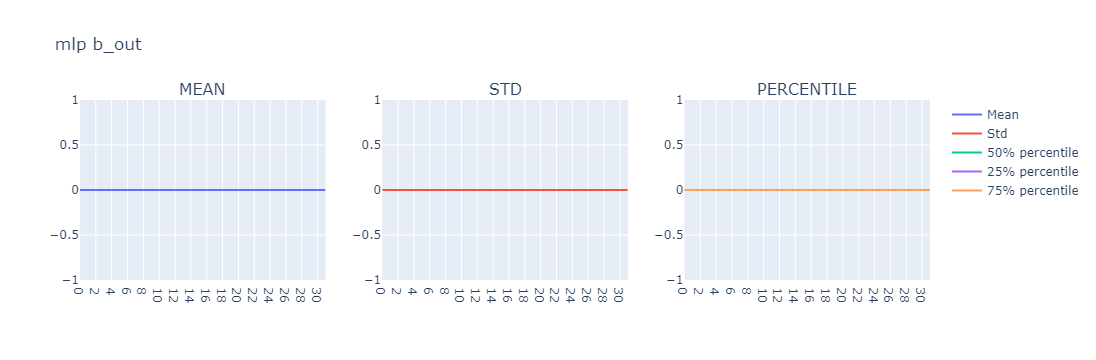

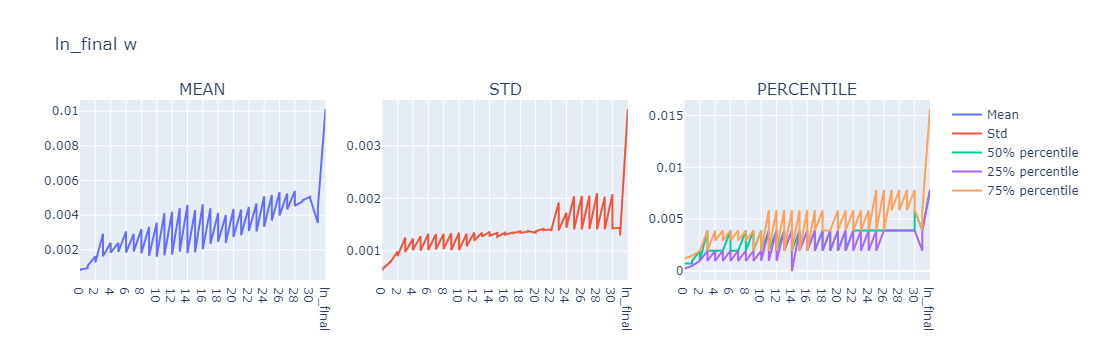

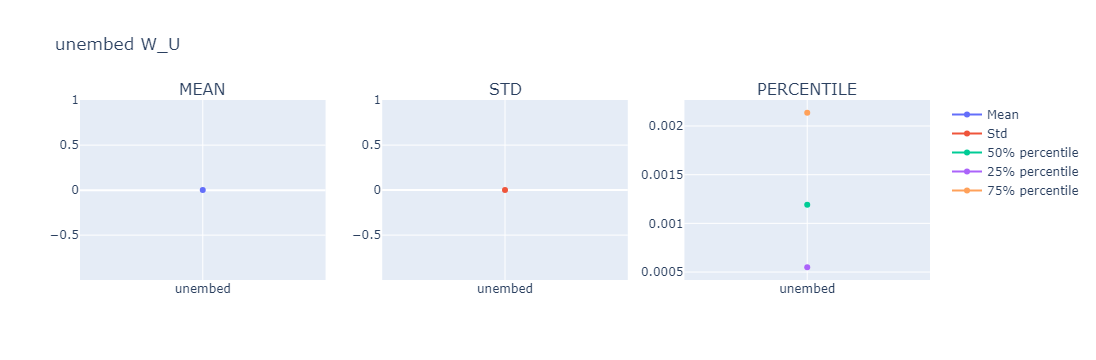

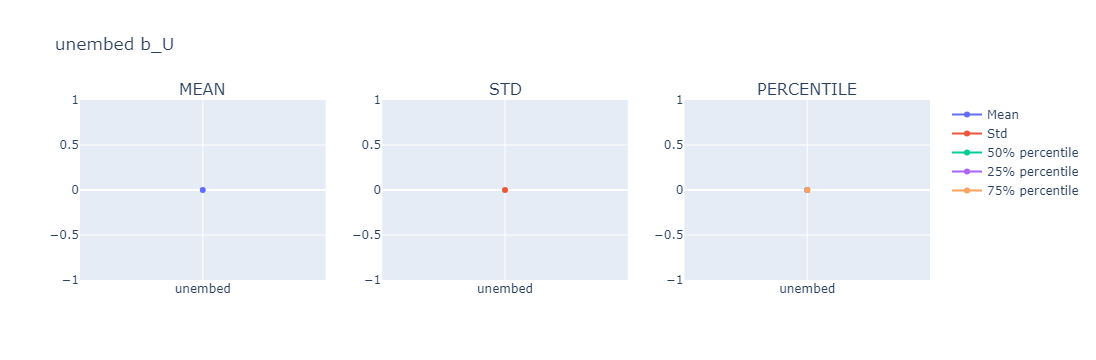

In [408]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
for name,block in zip(param_name_unique,param_block_unique):
    df_plot = df[df["param_name_all"]==name]

    fig = make_subplots(rows = 1, cols = 3,
                        subplot_titles=("MEAN","STD","PERCENTILE"))
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["mean_param_diff"].values, name = "Mean"),
                row=1,col=1,
               )
    
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["std_param_diff"].values,name = "Std"),
                row=1,col=2,
                )

    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["median_param_diff"].values,name = '50% percentile'),
                row=1,col=3,
                )
    
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["first_quarter_param_diff"].values,name = '25% percentile'),
                row=1,col=3,
                )
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["last_quarter_param_diff"].values,name = '75% percentile'),
                row=1,col=3,
                )
    fig.update_layout(title_text = block +" " +name)
    fig.show()

76.54180565392382

# Mean, variance  of parapemter

In [ ]:
df = pd.DataFrame()

param_name_all = []
param_block_all = []
param_layer_all = []

mean_param_base = [] 
mean_param_chat = []

std_param_base = []
std_param_chat = []

median_param_base = []
median_param_chat = []

first_quarter_param_base = []
first_quarter_param_chat = []

last_quarter_param_base = []
last_quarter_param_chat = [] 

cc =0
for (name, param),(name_chat, param_chat) in zip(model_tl_7b.named_parameters(), model_tl_7b_chat.named_parameters()):
    
    if name.startswith(f"blocks."):
        param_name = name.split(".")[-1]
        param_block = name.split(".")[2]
        param_layer = name.split(".")[1]
        # print(param_name)
        # print(param_block)
        # print(param_layer)
        param_name_all = np.append(param_name_all,param_name)
        param_block_all = np.append(param_block_all,param_block)
        param_layer_all = np.append(param_layer_all,param_layer)

    else:
        param_name = name.split(".")[-1]
        param_block = " "
        param_layer = name.split(".")[0]

        # print(param_name)
        # print(param_block)
        # print(param_layer) 
        param_name_all = np.append(param_name_all,param_name)
        param_block_all = np.append(param_block_all,param_block)
        param_layer_all = np.append(param_layer_all,param_layer)


    param_chat = param_chat
    param_chat = to_numpy(param_chat)
    param_base = param
    param_base = to_numpy(param_base)  
    
    mean_param_base = np.append(mean_param_base,np.mean(param_base))
    mean_param_chat = np.append(mean_param_chat,np.mean(param_chat))

    std_param_base = np.append(std_param_base,np.std(param_base))
    std_param_chat = np.append(std_param_chat,np.std(param_chat))

    median_param_base = np.append(median_param_base,np.median(param_base))
    median_param_chat = np.append(median_param_chat,np.median(param_chat))

    first_quarter_param_base = np.append(first_quarter_param_base,np.percentile(param_base,25))
    first_quarter_param_chat = np.append(first_quarter_param_chat,np.percentile(param_chat,25))

    last_quarter_param_base = np.append(last_quarter_param_base,np.percentile(param_base,75))
    last_quarter_param_chat = np.append(last_quarter_param_chat,np.percentile(param_chat,75))

df["param_layer_all"] = param_layer_all
df["param_block_all"] = param_block_all
df["param_name_all"] = param_name_all

df["mean_param_base"] = mean_param_base
df["mean_param_chat"] = mean_param_chat

df["std_param_base"] = std_param_base
df["std_param_chat"] = std_param_chat

df["median_param_base"] = median_param_base
df["median_param_chat"] = median_param_chat

df["first_quarter_param_base"] = first_quarter_param_base
df["first_quarter_param_chat"] = first_quarter_param_chat

df["last_quarter_param_base"] = last_quarter_param_base
df["last_quarter_param_chat"] = last_quarter_param_chat

In [414]:
df

param_layer_all param_block_all param_name_all  mean_param_base  \
0             embed                            W_E        -0.000047   
1                 0             ln1              w         0.015698   
2                 0             ln2              w         0.054552   
3                 0            attn            W_Q       128.270097   
4                 0            attn            W_O       139.133292   
..              ...             ...            ...              ...   
479              31             mlp           b_in         0.000000   
480              31             mlp          b_out         0.000000   
481        ln_final                              w         1.781836   
482         unembed                            W_U        -0.000014   
483         unembed                            b_U         0.000000   

     mean_param_chat  std_param_base  std_param_chat  median_param_base  \
0          -0.000047        0.016961        0.016815          -0.000005   
1           0.015858        0.034913        0.034652           0.010437   
2           0.054035        0.011192        0.011217           0.053223   
3         128.330202       75.168438       75.176769         129.000000   
4         139.188619       73.537226       73.518717         129.000000   
..               ...             ...             ...                ...   
479         0.000000        0.000000        0.000000           0.000000   
480         0.000000        0.000000        0.000000           0.000000   
481         1.771715        0.116984        0.116118           1.773438   
482        -0.000011        0.017283        0.016762           0.000002   
483         0.000000        0.000000        0.000000           0.000000   

     median_param_chat  first_quarter_param_base  first_quarter_param_chat  \
0            -0.000005                 -0.011353                 -0.011230   
1             0.010681                  0.007812                  0.007996   
2             0.052734                  0.049561                  0.049072   
3           129.000000                 69.000000                 69.000000   
4           129.000000                 85.000000                 85.000000   
..                 ...                       ...                       ...   
479           0.000000                  0.000000                  0.000000   
480           0.000000                  0.000000                  0.000000   
481           1.765625                  1.726562                  1.718750   
482           0.000004                 -0.011292                 -0.010925   
483           0.000000                  0.000000                  0.000000   

     last_quarter_param_base  last_quarter_param_chat  
0                   0.011230                 0.011169  
1                   0.013687                 0.014038  
2                   0.057617                 0.057129  
3                 197.000000               197.000000  
4                 213.000000               213.000000  
..                       ...                      ...  
479                 0.000000                 0.000000  
480                 0.000000                 0.000000  
481                 1.828125                 1.820312  
482                 0.011292                 0.010925  
483                 0.000000                 0.000000  

[484 rows x 13 columns]

In [416]:
name

'b_U'

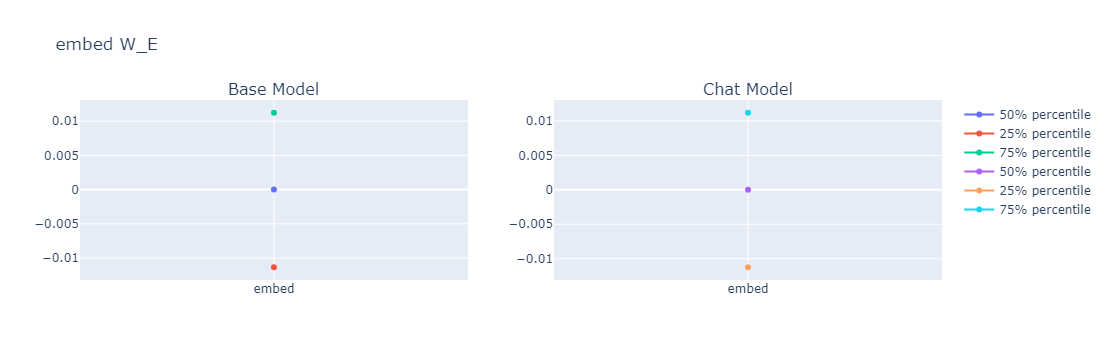

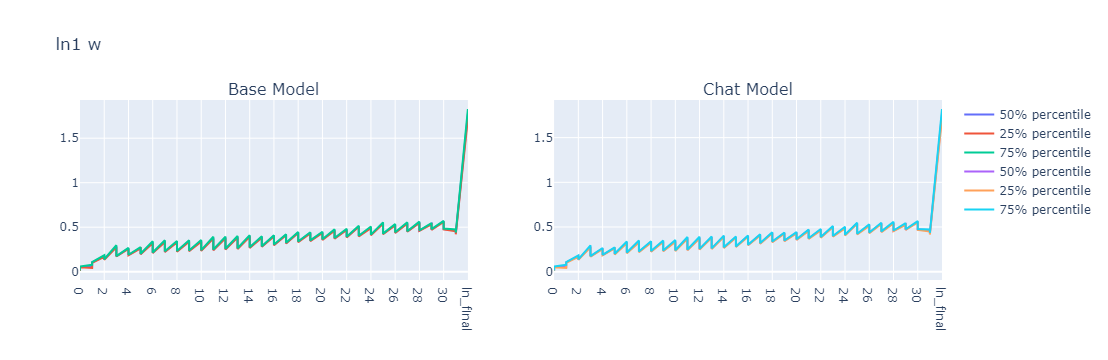

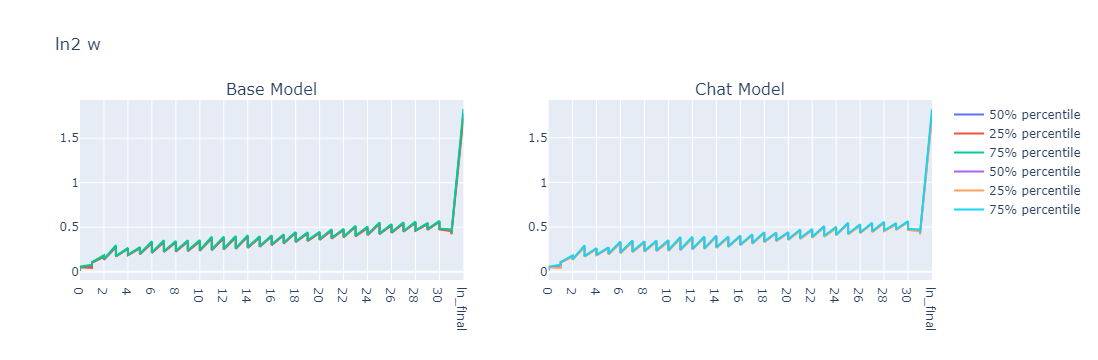

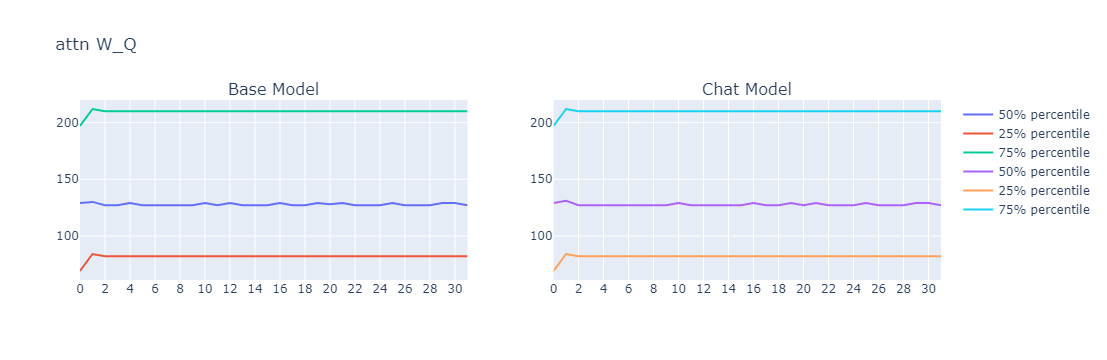

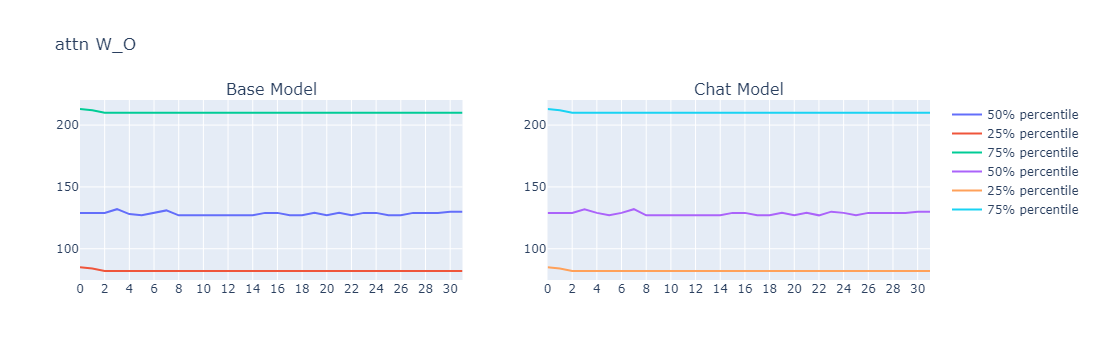

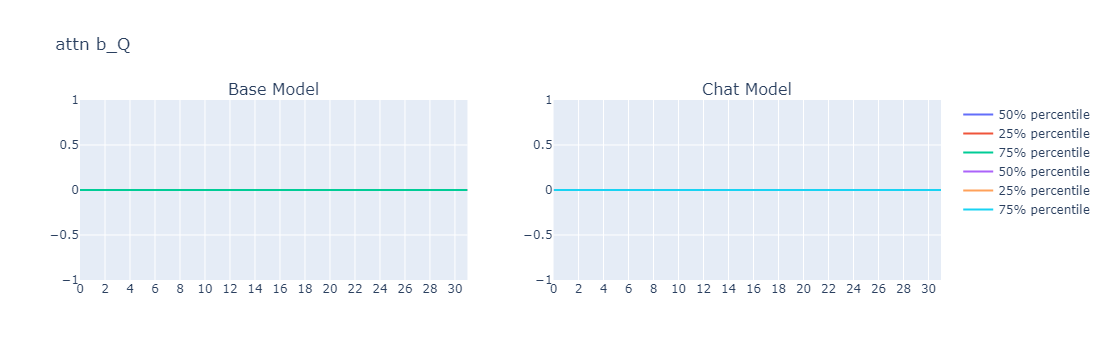

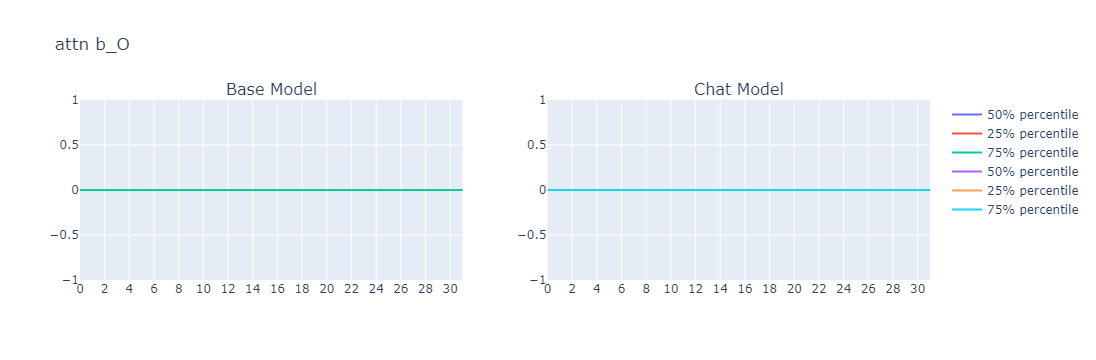

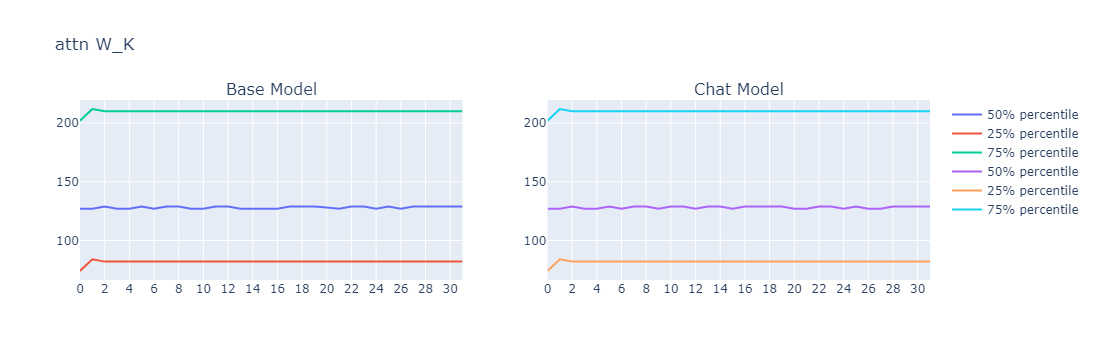

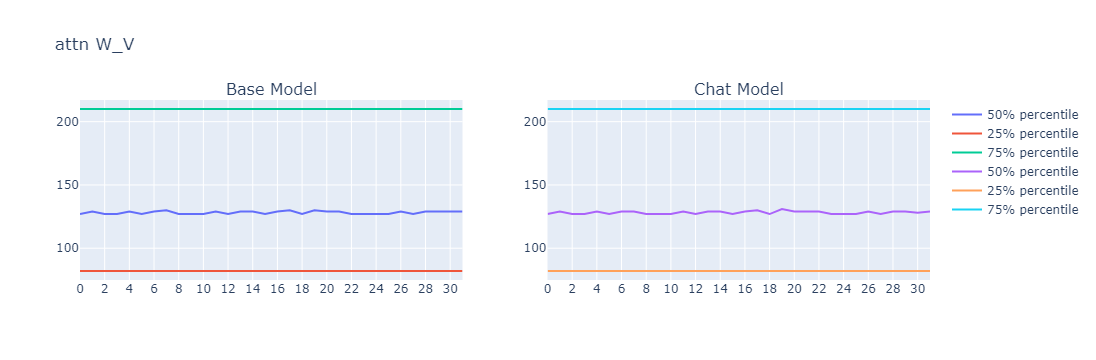

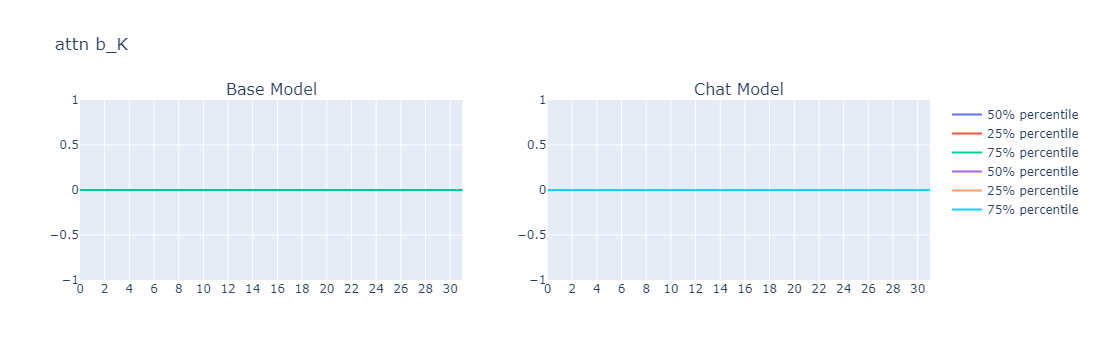

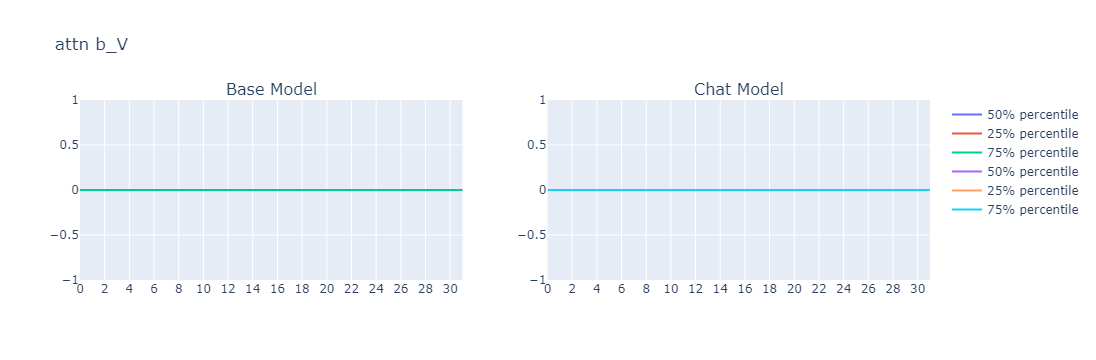

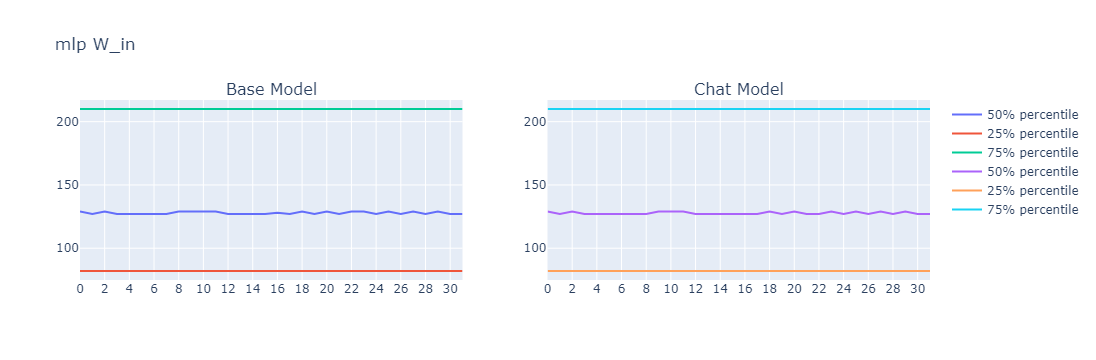

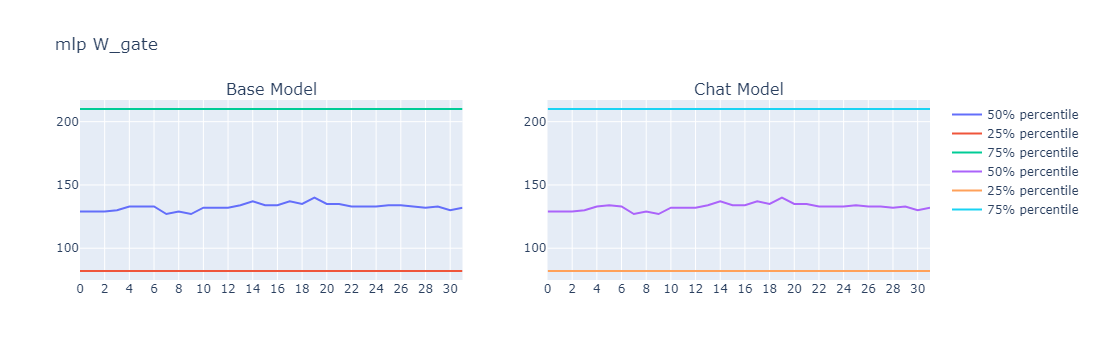

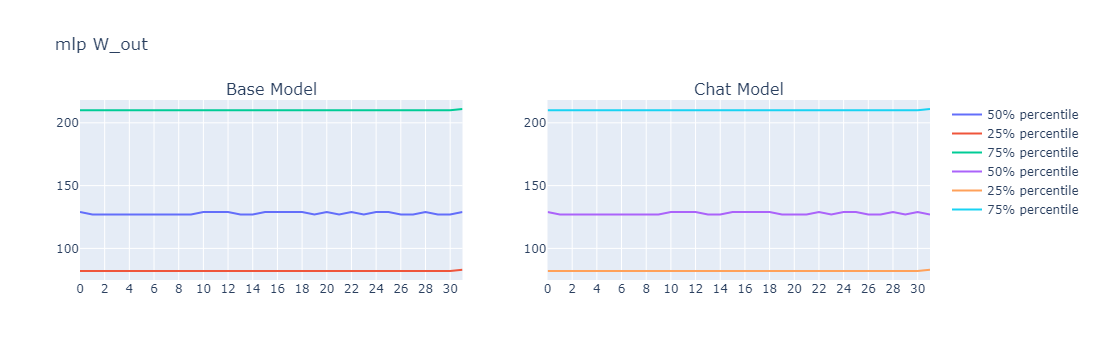

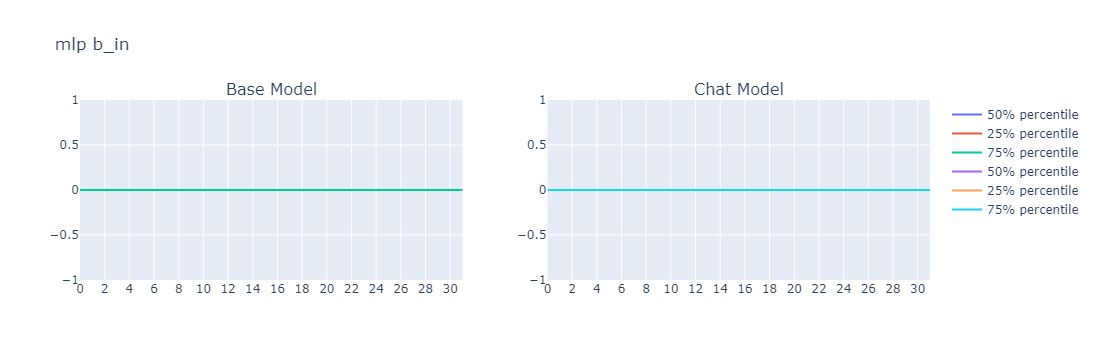

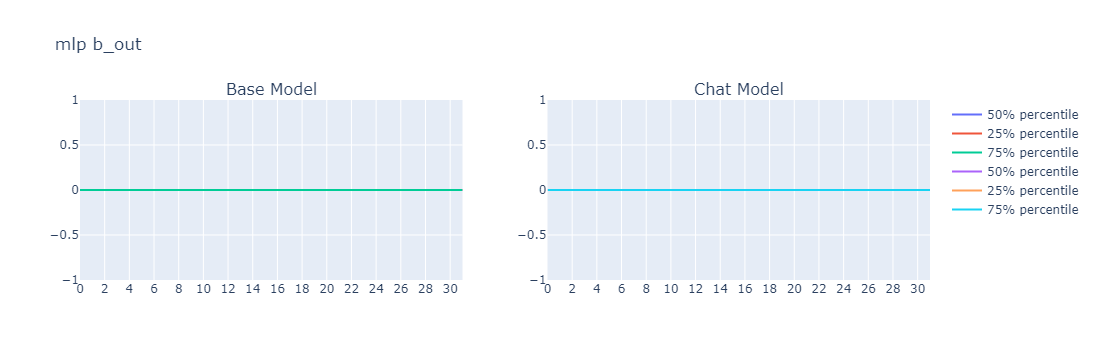

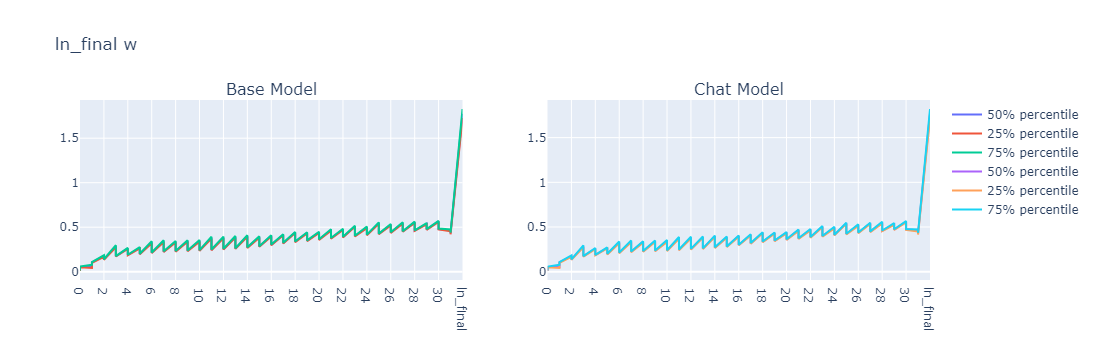

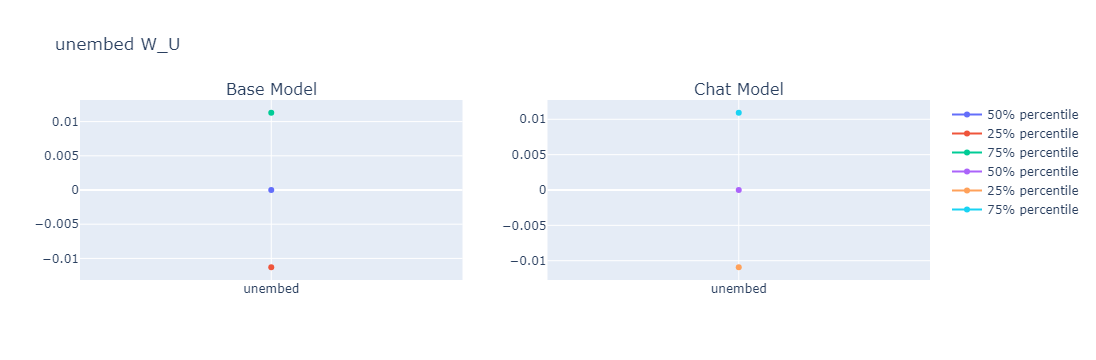

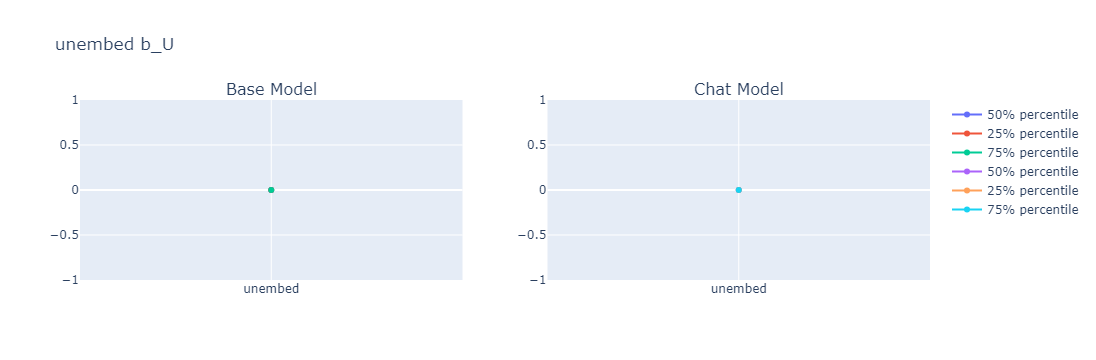

In [412]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
for name,block in zip(param_name_unique,param_block_unique):
    df_plot = df[df["param_name_all"]==name]

    fig = make_subplots(rows = 1, cols = 2,
                        subplot_titles=("Base Model","Chat Model"))
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["median_param_base"].values,name = '50% percentile'),
                row=1,col=1,
                )
    
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["first_quarter_param_base"].values,name = '25% percentile'),
                row=1,col=1,
                )
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["last_quarter_param_base"].values,name = '75% percentile'),
                row=1,col=1,
                )

    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["median_param_chat"].values,name = '50% percentile'),
                row=1,col=2,
                )
    
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["first_quarter_param_chat"].values,name = '25% percentile'),
                row=1,col=2,
                )
    fig.add_trace(
        go.Scatter(
                x = df_plot["param_layer_all"].values, y = df_plot["last_quarter_param_chat"].values,name = '75% percentile'),
                row=1,col=2,
                )
    fig.update_layout(title_text = block +" " +name)
    fig.show()